In [1]:
import warnings

import numpy as np
import pandas as pd

# Импорт необходимых модулей
from scripts.calibrate_models import calibrate_fx_model, calibrate_models
from scripts.compare_models import compare_models, create_model
from scripts.simulate_model import simulate_model
from src.visualization.plots import plot_fx_analysis, plot_historical_data, plot_simulation
from src.visualization.stats import print_best_params, print_statistics

warnings.filterwarnings("ignore")

# SORF

In [2]:
raw_sofr_df = pd.read_excel("data/us-sofr.xlsx")
raw_sofr_df = raw_sofr_df.rename(columns={"Effective Date": "Date", "Rate (%)": "Rate"})[
    ["Date", "Rate"]
]
raw_sofr_df["Date"] = pd.to_datetime(raw_sofr_df["Date"])
raw_sofr_df["Rate"] = raw_sofr_df["Rate"] / 100

# Фильтруем данные до нашей расчетной даты
calc_date = pd.Timestamp("2021-12-10")
start_date = raw_sofr_df["Date"].min()  # calc_date - pd.Timedelta(days=365 * 3)
end_date = calc_date + pd.Timedelta(days=365)
sofr_hist = raw_sofr_df[raw_sofr_df["Date"] <= calc_date].copy()
sofr_df = sofr_hist.dropna()

# Берем ставку на расчетную дату
sofr_initial = sofr_hist[sofr_hist["Date"] == calc_date]["Rate"].values[0]
print(f"Начальная ставка SOFR на 10.12.2021: {sofr_initial * 100:.4f}%")

Начальная ставка SOFR на 10.12.2021: 0.0500%


СТАТИСТИКА ДАННЫХ (СТАВКА):
• Объем данных: 925 наблюдений
• Минимальный ставка: 0.0100 %
• Максимальный ставка: 5.2500 %
• Средний ставка: 1.1053 %
• Медиана: 1.5400 %
• Стандартное отклонение: 1.0318 %
• Коэффициент вариации: 0.9335

• 25-й перцентиль: 0.0500 %
• 75-й перцентиль: 2.1200 %
• IQR: 2.0700 %

Анализ изменений ставок:
• Среднее дневное изменение: 0.0019%
• Волатильность изменений: 0.1437%
• Макс. рост за день: 2.7000%
• Макс. падение за день: -2.8200%


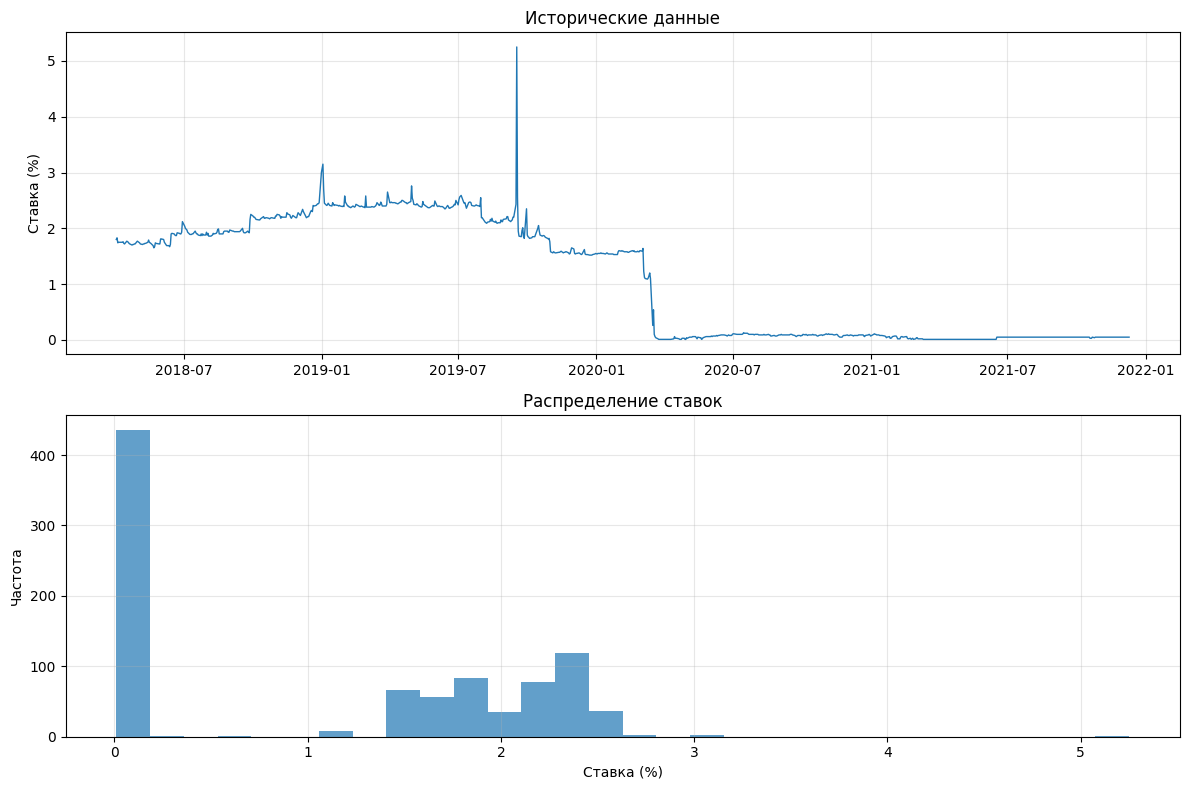

In [3]:
print_statistics(sofr_df["Rate"])
plot_historical_data(sofr_df)


Калибровка моделей...
1. Модель с постоянной theta...
   α=0.0010, σ=0.1764, θ=0.0003
Условие Феллера (2αθ > σ²): НЕ ВЫПОЛНЕНО
2. Модель с линейной theta...
   α=0.9575, σ=0.1758, θ(t)=0.0001 + 0.0066·t
Условие Феллера (2αθ(t₀) > σ²): НЕ ВЫПОЛНЕНО
3. Модель с периодической theta...
   α=0.0202, σ=0.1760, θ(t)=0.1901 + 0.1505·sin(2π·10.0000·t)
Условие Феллера (2αθ_сред > σ²): НЕ ВЫПОЛНЕНО

Симуляция constant модели...


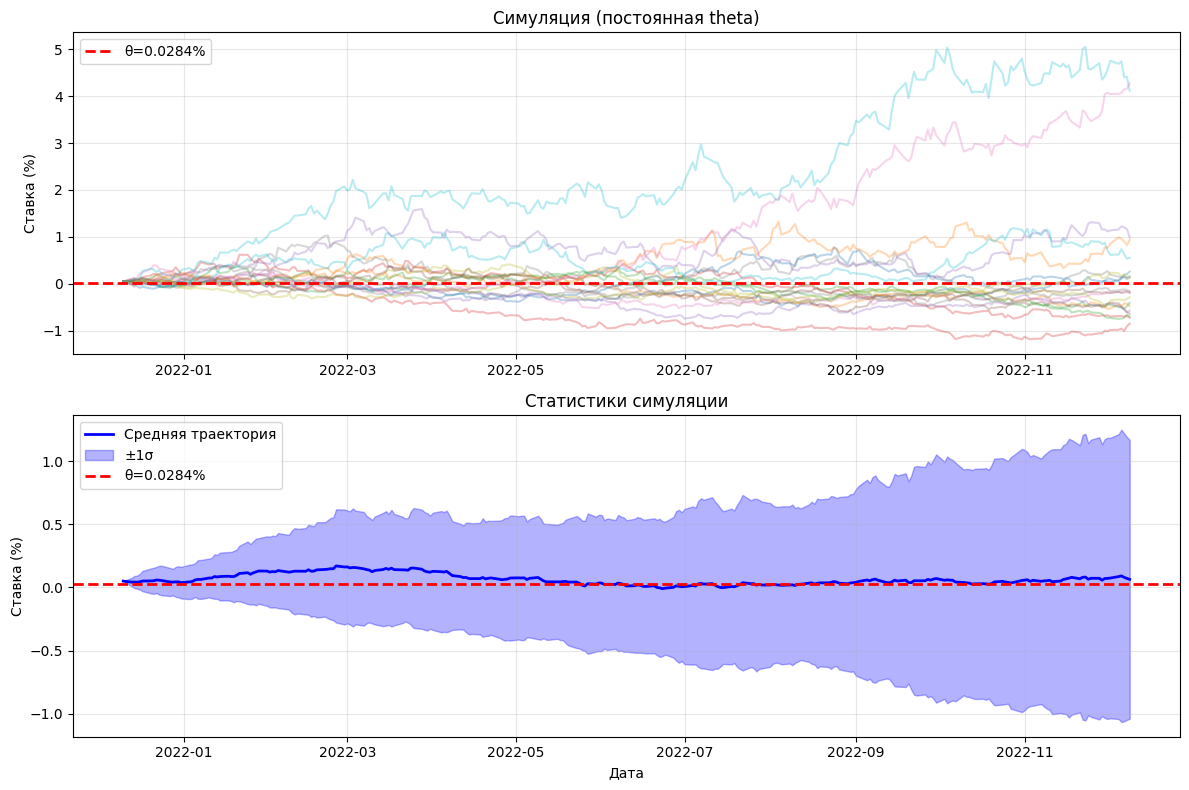


Симуляция linear модели...


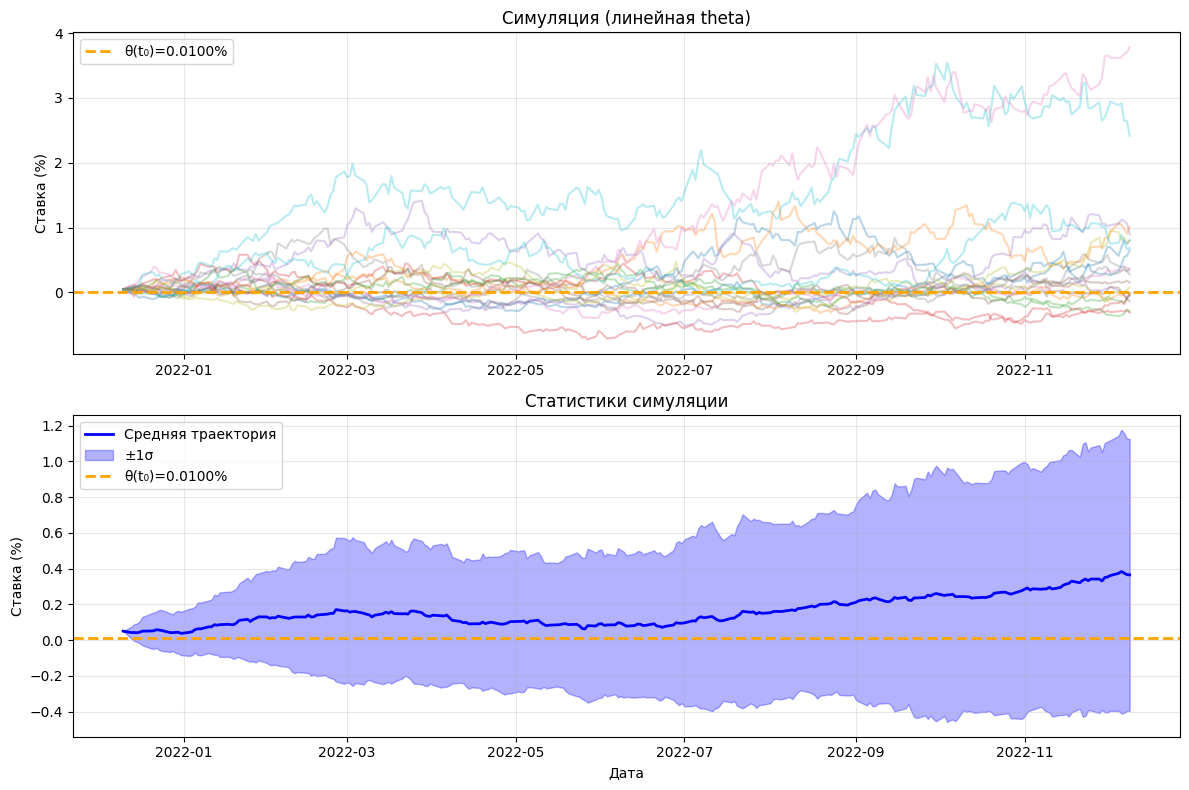


Симуляция periodic модели...


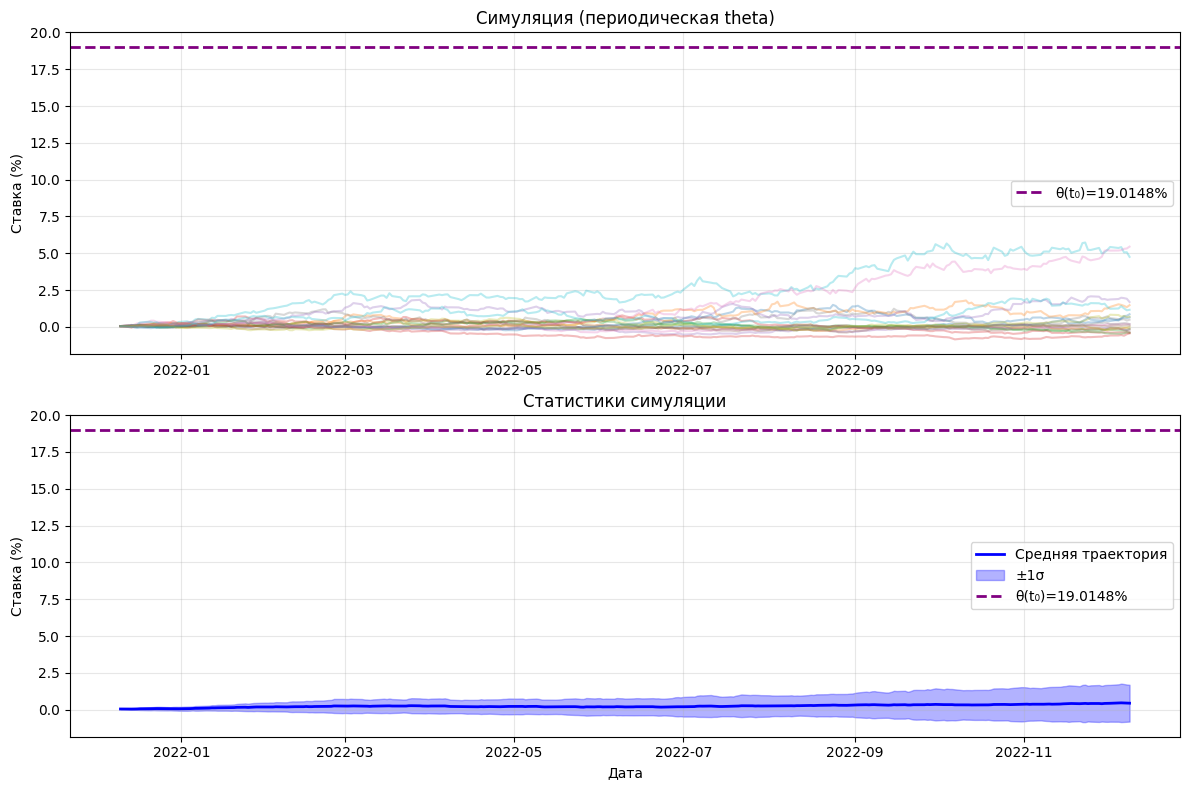

In [4]:
# Калибровка
models = calibrate_models(sofr_df["Rate"].values, mode="sofr")

# Симуляция для каждой модели
for model_type in models:
    print(f"\nСимуляция {model_type} модели...")
    model = create_model(models[model_type], model_type)
    dates, trajectories = simulate_model(
        model=model,
        initial_value=sofr_initial,
        start_date=calc_date,
        end_date=end_date,
        n_paths=50,
        model_type="rate",
    )
    plot_simulation(dates, trajectories, model_type, models[model_type])


СРАВНЕНИЕ МОДЕЛЕЙ
Constant θ: LogL = 5494.2631
Linear θ: LogL = 5497.2451
Periodic θ: LogL = 5496.1676

Лучшая модель: linear theta
Log-правдоподобие: 5497.2451
Улучшение vs постоянная: +0.0543

График сравнения моделей...


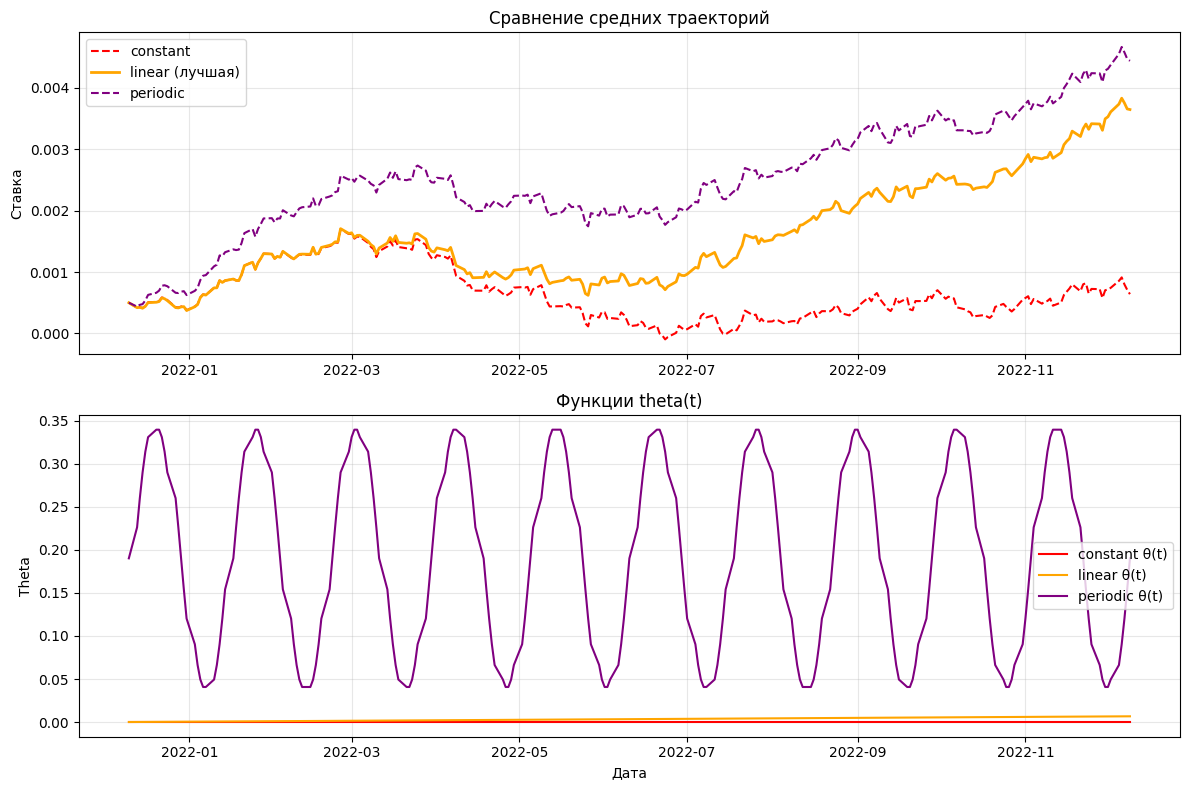


Параметры лучшей модели (linear):
• Alpha (α): 0.9575
• Sigma (σ): 0.1758
• Theta(t): 0.0001 + 0.0066·t


In [5]:
best_type = compare_models(models, sofr_initial, calc_date, end_date)
print_best_params(models, best_type)

СТАТИСТИКА ДАННЫХ (СТАВКА):
• Объем данных: 249 наблюдений
• Минимальный ставка: 0.0400 %
• Максимальный ставка: 3.8200 %
• Средний ставка: 1.4028 %
• Медиана: 0.7900 %
• Стандартное отклонение: 1.3064 %
• Коэффициент вариации: 0.9313

• 25-й перцентиль: 0.0500 %
• 75-й перцентиль: 2.2900 %
• IQR: 2.2400 %

Анализ изменений ставок:
• Среднее дневное изменение: -0.0151%
• Волатильность изменений: 0.1004%
• Макс. рост за день: 0.0400%
• Макс. падение за день: -0.7500%


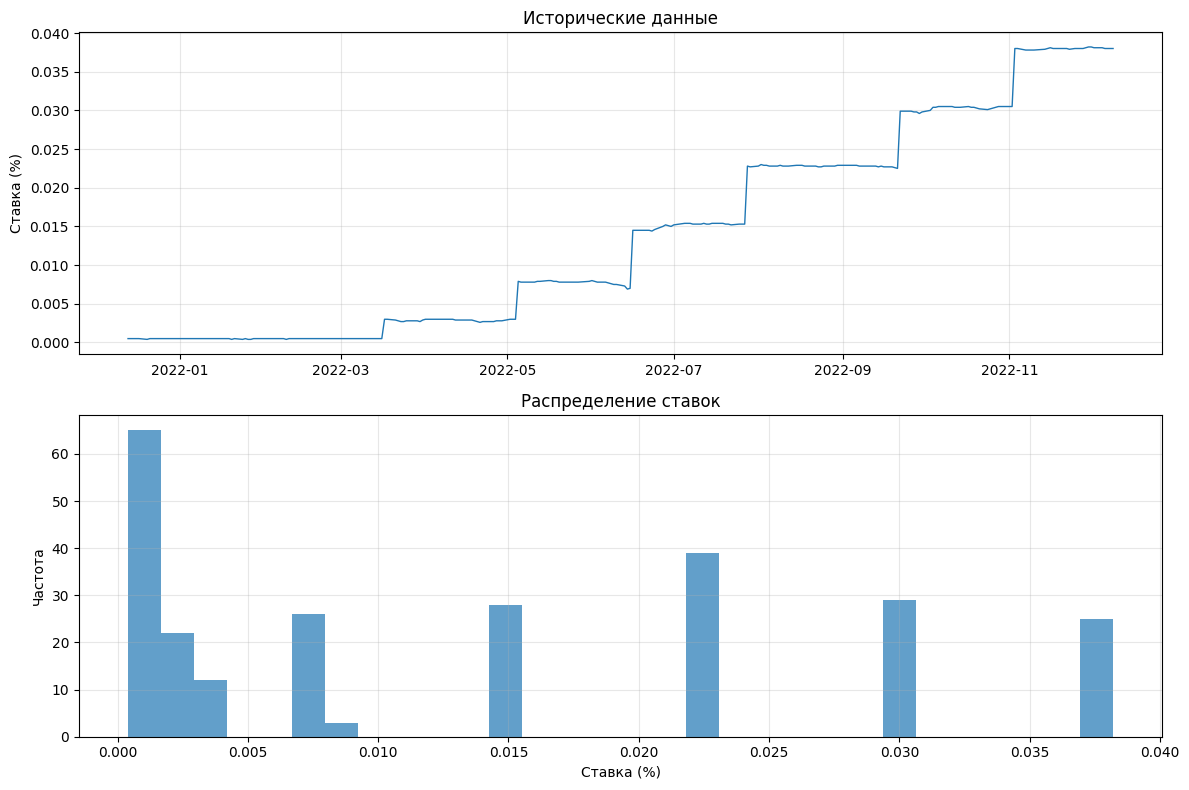

In [6]:
# Фильтруем данные после нашей расчетной даты
sofr_future = raw_sofr_df[
    (raw_sofr_df["Date"] > calc_date) & (raw_sofr_df["Date"] <= end_date)
].copy()
sofr_future = sofr_future.dropna()
sofr_future["Rate"] = sofr_future["Rate"] / 100
print_statistics(sofr_future["Rate"] * 100)
plot_historical_data(sofr_future)

# RUONIO

In [7]:
raw_ruonio_df = pd.read_excel("data/ru-ruonio.xlsx")
raw_ruonio_df = raw_ruonio_df.rename(columns={"DT": "Date", "ruo": "Rate"})[["Date", "Rate"]]
raw_ruonio_df["Date"] = pd.to_datetime(raw_ruonio_df["Date"])
raw_ruonio_df["Rate"] = raw_ruonio_df["Rate"]

start_date = raw_ruonio_df["Date"].max()

# Фильтруем данные до нашей расчетной даты
ruonio_hist = raw_ruonio_df[raw_ruonio_df["Date"] <= calc_date].copy()
ruonio_df = ruonio_hist.dropna()
ruonio_df["Rate"] = ruonio_df["Rate"] / 100

# Берем ставку на расчетную дату
ruonio_initial = ruonio_df[ruonio_df["Date"] == calc_date]["Rate"].values[0]
print(f"Начальная ставка SOFR на 10.12.2021: {ruonio_initial * 100:.4f}%")

Начальная ставка SOFR на 10.12.2021: 7.4500%


СТАТИСТИКА ДАННЫХ (СТАВКА):
• Объем данных: 2939 наблюдений
• Минимальный ставка: 0.4200 %
• Максимальный ставка: 28.6500 %
• Средний ставка: 6.9710 %
• Медиана: 6.5200 %
• Стандартное отклонение: 2.9564 %
• Коэффициент вариации: 0.4241

• 25-й перцентиль: 4.8950 %
• 75-й перцентиль: 8.3850 %
• IQR: 3.4900 %

Анализ изменений ставок:
• Среднее дневное изменение: -0.0015%
• Волатильность изменений: 0.3280%
• Макс. рост за день: 4.3500%
• Макс. падение за день: -6.8500%


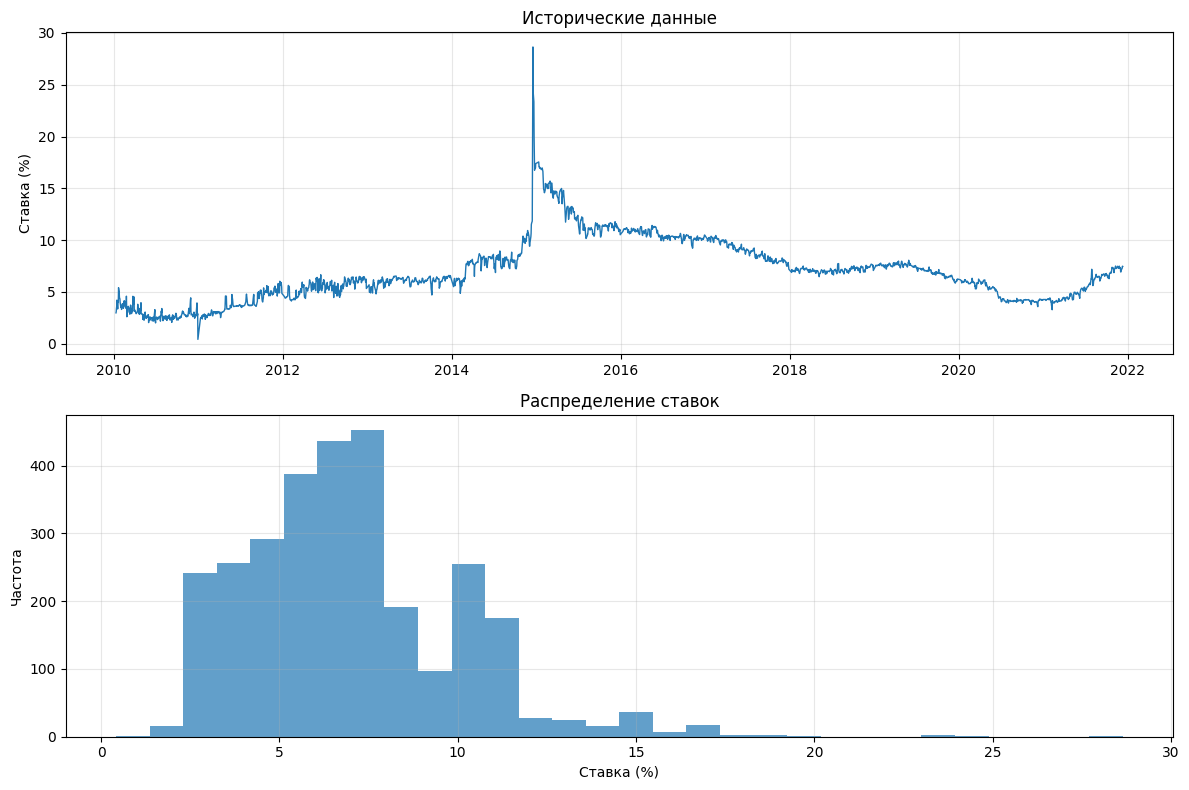

In [8]:
print_statistics(ruonio_df["Rate"])
plot_historical_data(ruonio_df)


Калибровка моделей...
1. Модель с постоянной theta...
   α=3.3964, σ=0.2126, θ=0.0686
Условие Феллера (2αθ > σ²): ВЫПОЛНЕНО
2. Модель с линейной theta...
   α=3.4111, σ=0.2126, θ(t)=0.0691 + -0.0001·t
Условие Феллера (2αθ(t₀) > σ²): ВЫПОЛНЕНО
3. Модель с периодической theta...
   α=3.3946, σ=0.2126, θ(t)=0.0686 + 0.0001·sin(2π·0.0010·t)
Условие Феллера (2αθ_сред > σ²): ВЫПОЛНЕНО

Симуляция constant модели...


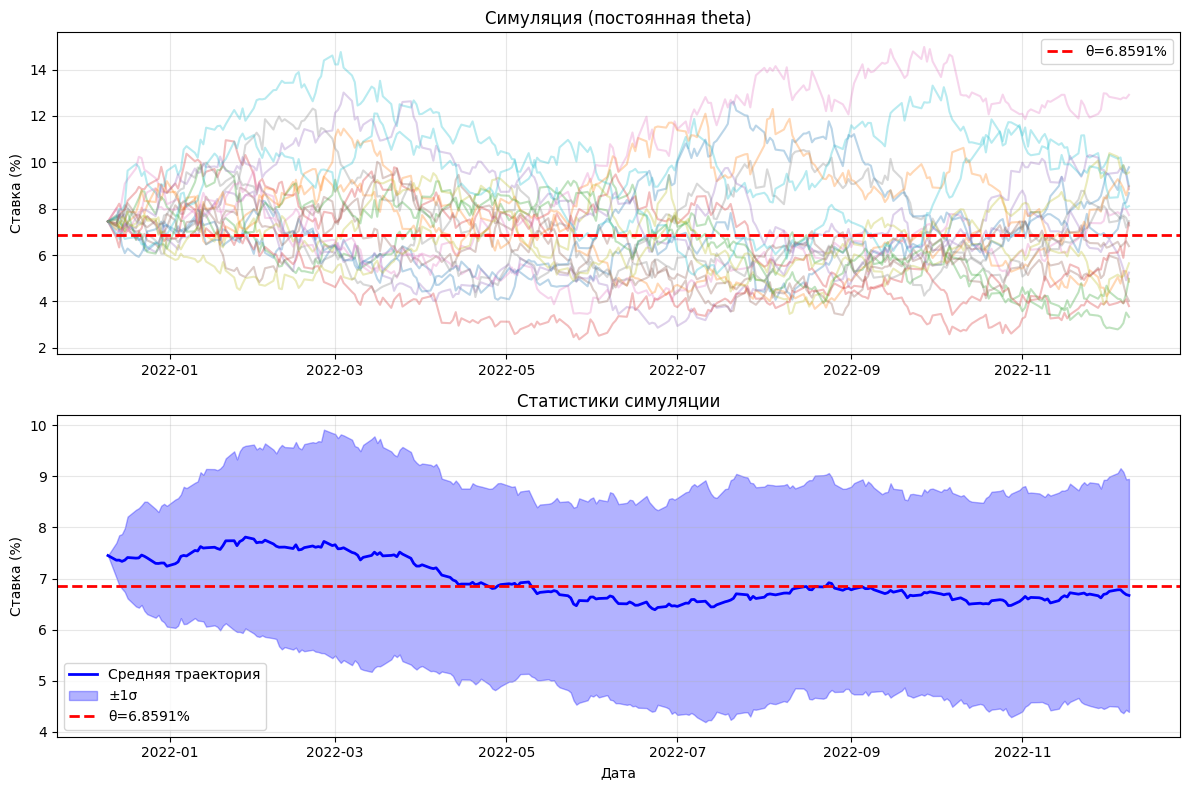


Симуляция linear модели...


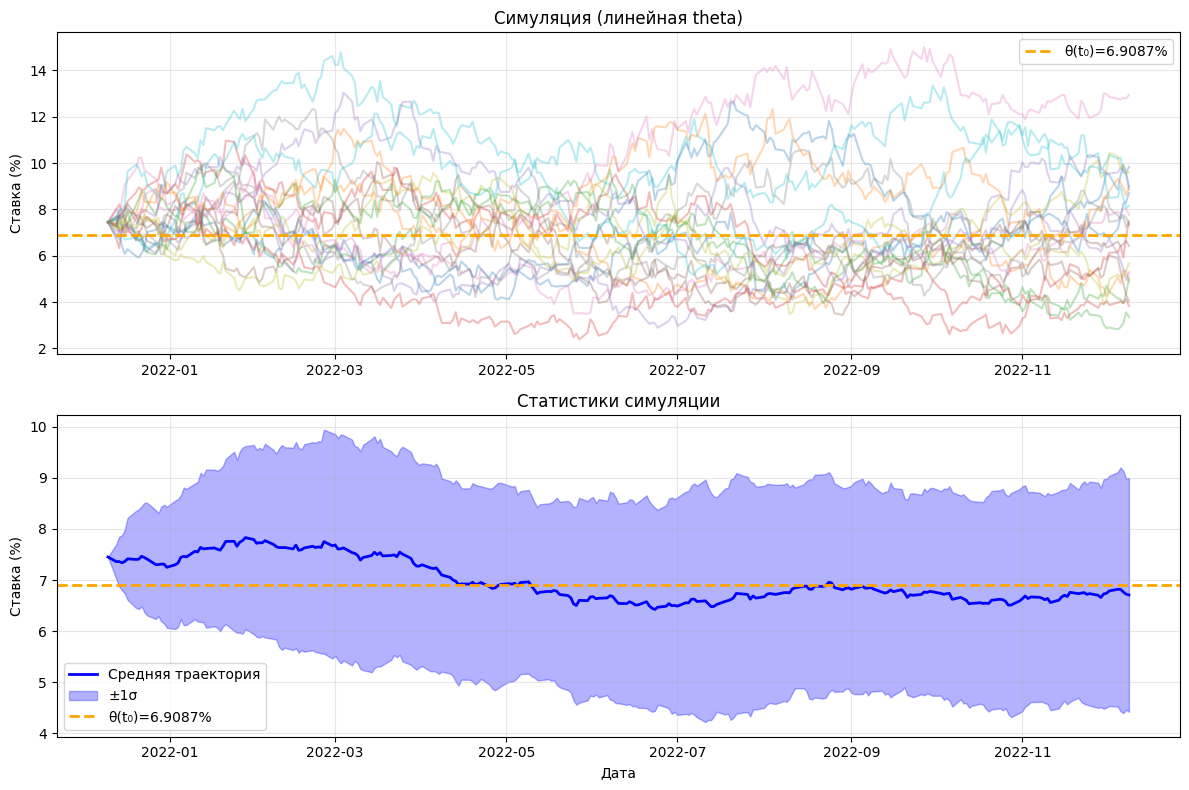


Симуляция periodic модели...


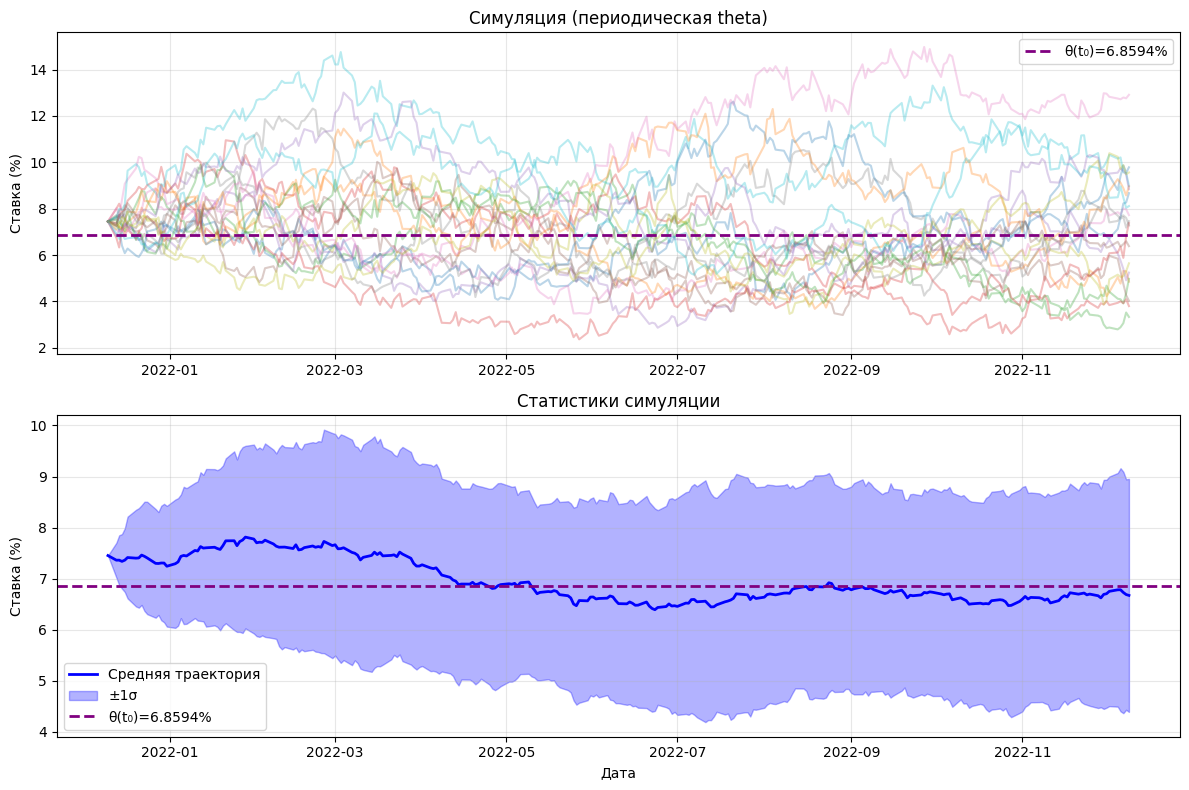

In [9]:
# Калибровка
models = calibrate_models(ruonio_df["Rate"].values, mode="rub")

# Симуляция для каждой модели
for model_type in models:
    print(f"\nСимуляция {model_type} модели...")
    model = create_model(models[model_type], model_type)
    dates, trajectories = simulate_model(
        model=model,
        initial_value=ruonio_initial,
        start_date=calc_date,
        end_date=end_date,
        n_paths=50,
        model_type="rate",
    )
    simulate_model(model, ruonio_initial, calc_date, end_date)
    plot_simulation(dates, trajectories, model_type, models[model_type])


СРАВНЕНИЕ МОДЕЛЕЙ
Constant θ: LogL = 12547.4260
Linear θ: LogL = 12547.4283
Periodic θ: LogL = 12547.4260

Лучшая модель: linear theta
Log-правдоподобие: 12547.4283
Улучшение vs постоянная: +0.0000

График сравнения моделей...


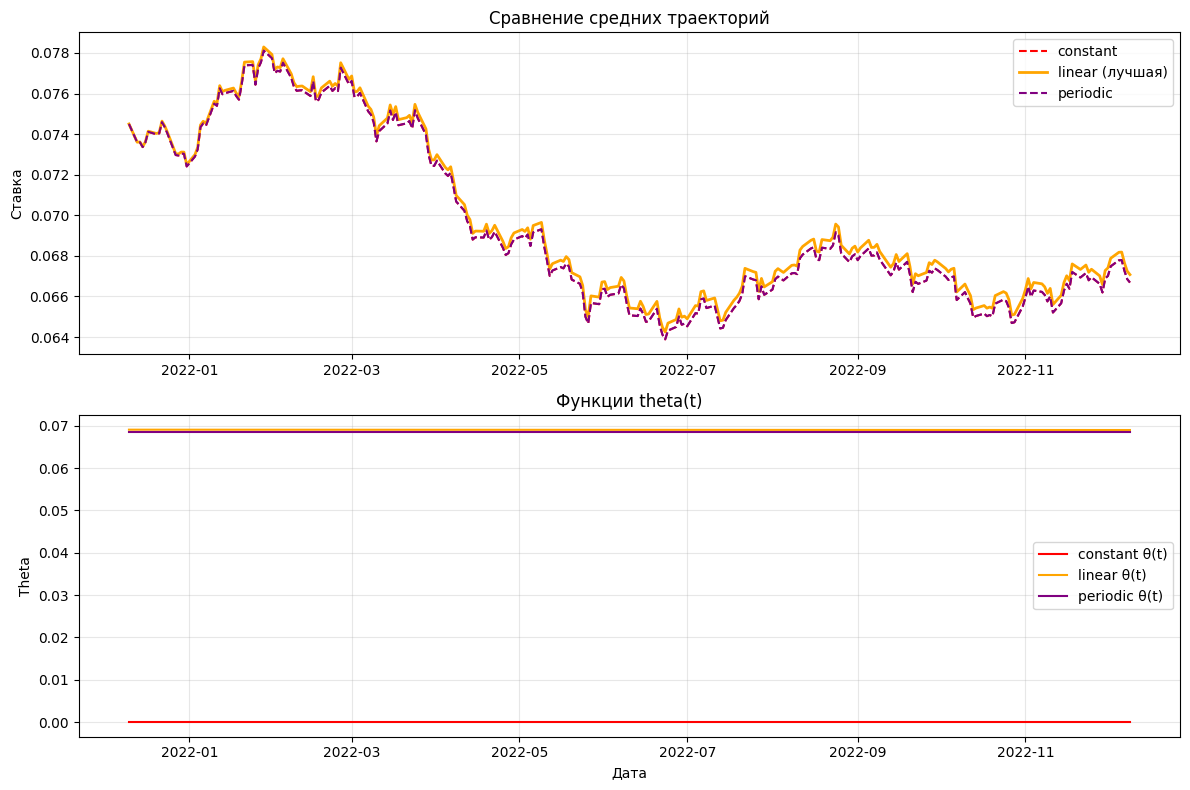


Параметры лучшей модели (linear):
• Alpha (α): 3.4111
• Sigma (σ): 0.2126
• Theta(t): 0.0691 + -0.0001·t


In [10]:
best_type = compare_models(models, ruonio_initial, calc_date, end_date)
print_best_params(models, best_type)

СТАТИСТИКА ДАННЫХ (СТАВКА):
• Объем данных: 245 наблюдений
• Минимальный ставка: 682.0000 %
• Максимальный ставка: 2121.0000 %
• Средний ставка: 1045.8367 %
• Медиана: 826.0000 %
• Стандартное отклонение: 420.2472 %
• Коэффициент вариации: 0.4018

• 25-й перцентиль: 774.0000 %
• 75-й перцентиль: 1070.0000 %
• IQR: 296.0000 %

Анализ изменений ставок:
• Среднее дневное изменение: 0.0410%
• Волатильность изменений: 74.2696%
• Макс. рост за день: 296.0000%
• Макс. падение за день: -1000.0000%


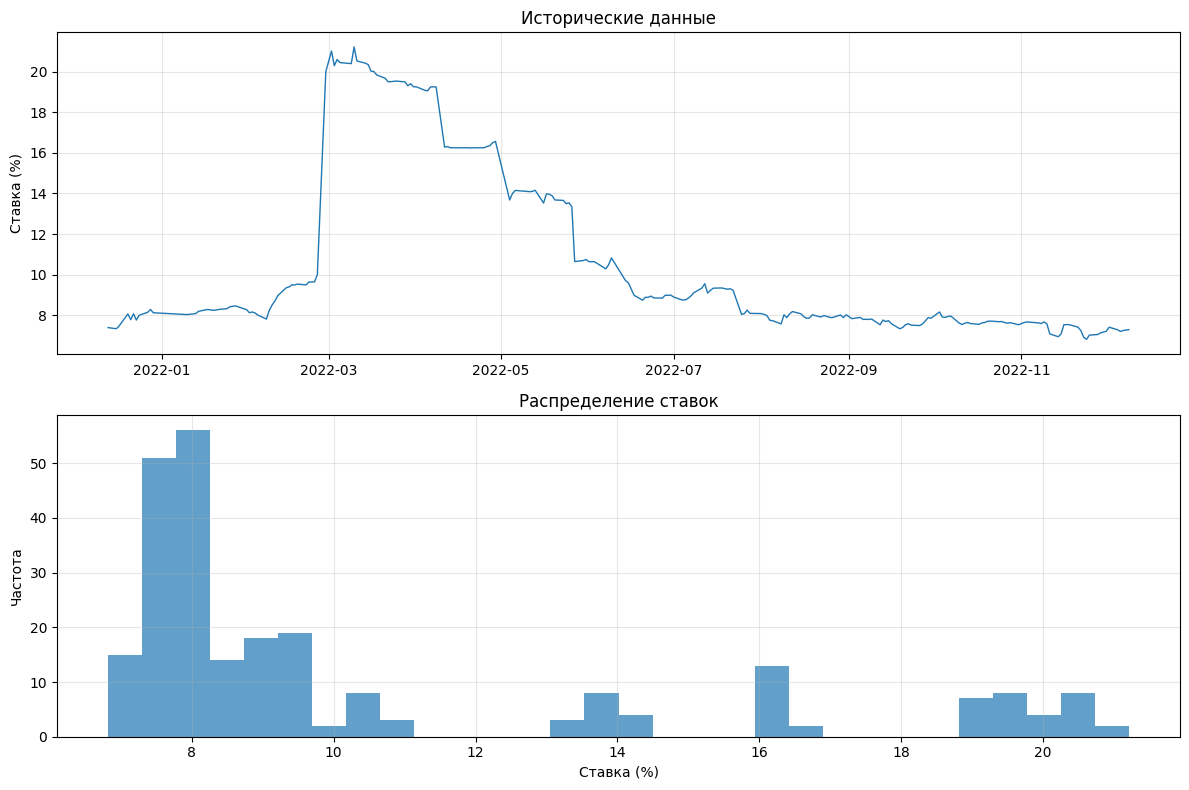

In [11]:
# Фильтруем данные после нашей расчетной даты
ruonio_future = raw_ruonio_df[
    (raw_ruonio_df["Date"] > calc_date) & (raw_ruonio_df["Date"] <= end_date)
].copy()
ruonio_future = ruonio_future.dropna()
ruonio_future["Rate"] = ruonio_future["Rate"] / 100
print_statistics(ruonio_future["Rate"] * 100)
plot_historical_data(ruonio_future)

# RUB/USD

In [12]:
fx_df = pd.read_excel("data/rub_usd.xlsx")
fx_df = fx_df.rename(columns={"data": "Date", "curs": "Rate"})
fx_df["Date"] = pd.to_datetime(fx_df["Date"])
fx_df = fx_df.sort_values("Date")

# Оставляем период до расчётной даты
calculation_date = pd.Timestamp("2021-12-10")
fx_hist = fx_df[fx_df["Date"] <= calculation_date].copy()
fx_hist = fx_hist.dropna(subset=["Rate"])

# Берём начальный курс S0 на дату 10.12.2021
fx_initial = fx_hist[fx_hist["Date"] == calculation_date]["Rate"].values[0]
print(f"Начальный курс на {calculation_date.date()}: {fx_initial:.4f} RUB за 1 USD")

Начальный курс на 2021-12-10: 73.5998 RUB за 1 USD


In [13]:
# Расчет лог-доходностей
fx_hist["LogRate"] = np.log(fx_hist["Rate"])
fx_hist["LogReturn"] = fx_hist["LogRate"].diff()
log_returns = fx_hist["LogReturn"].dropna()

In [14]:
print_statistics(fx_hist["Rate"], data_type="fx", log_returns=log_returns)

СТАТИСТИКА ДАННЫХ (КУРС):
• Объем данных: 1529 наблюдений
• Минимальный курс: 55.6717 RUB/USD
• Максимальный курс: 83.5913 RUB/USD
• Средний курс: 66.3481 RUB/USD
• Медиана: 65.3065 RUB/USD
• Стандартное отклонение: 6.1986 RUB/USD
• Коэффициент вариации: 0.0934

• 25-й перцентиль: 62.2556 RUB/USD
• 75-й перцентиль: 72.5553 RUB/USD
• IQR: 10.2997 RUB/USD

Анализ изменений курса:
• Среднее дневное изменение: 0.0001
• Волатильность изменений: 0.0089
• Макс. рост за день: 0.0646
• Макс. падение за день: -0.0392
• Эксцесс: 7.2310
• Асимметрия: 0.6946
• Тест на нормальность (p-value): 0.0000


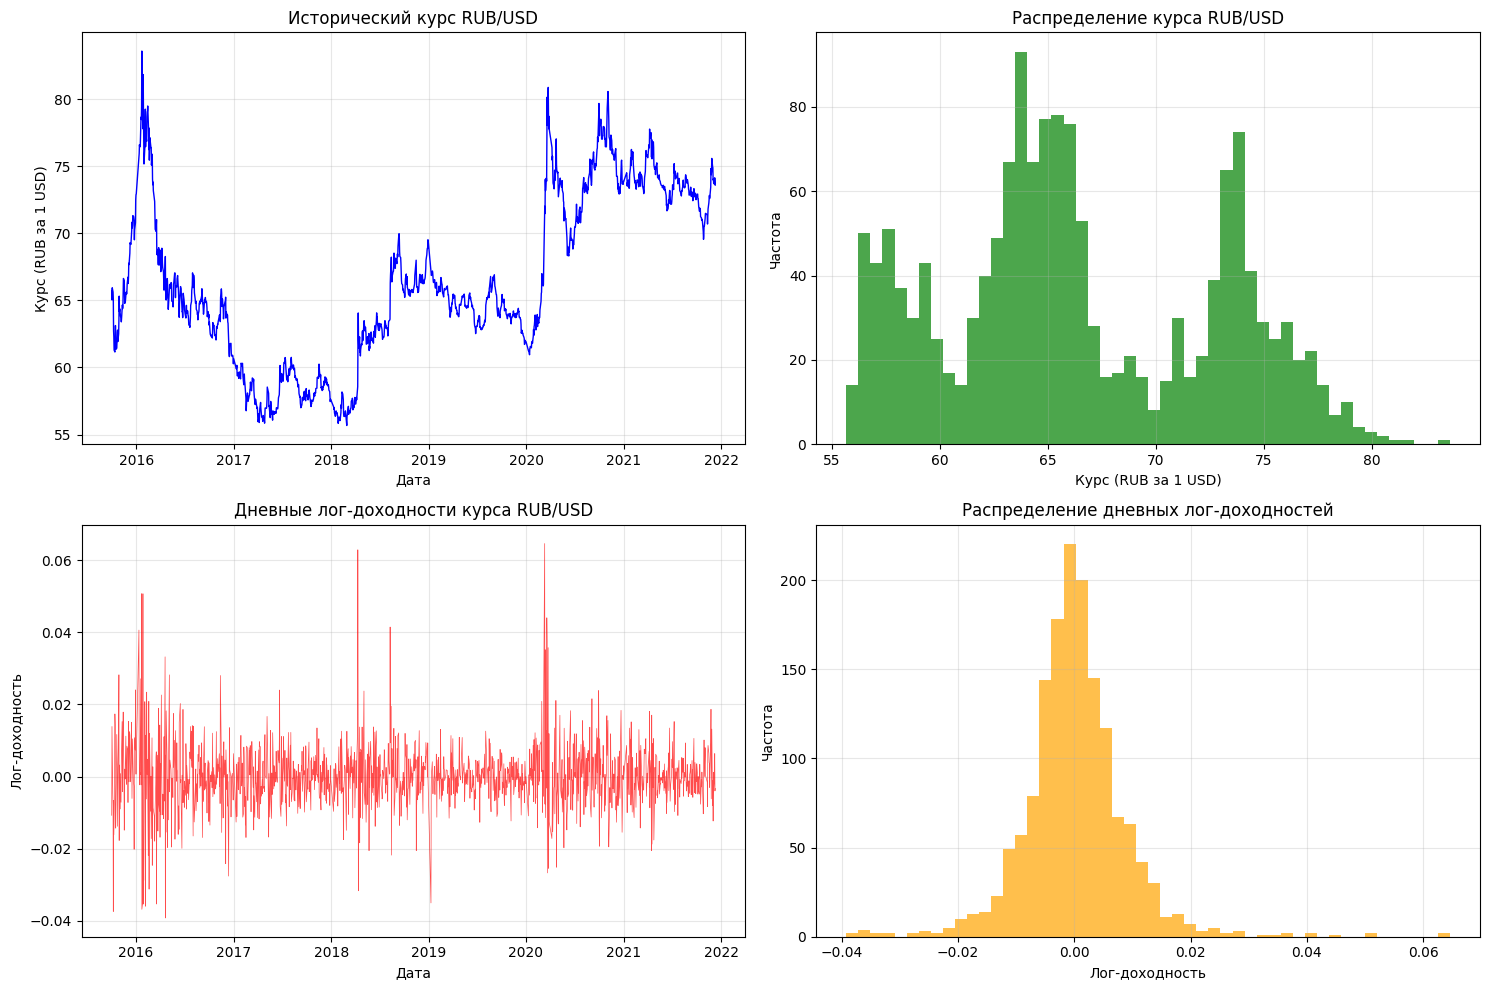

In [15]:
plot_fx_analysis(fx_hist, log_returns)

In [16]:
fx_params = calibrate_fx_model(log_returns)
fx_model = create_model(fx_params, "fx")
dates_fx_simple, trajectories_fx_simple = simulate_model(
    model=fx_model,
    initial_value=fx_initial,
    start_date=calc_date,
    end_date=end_date,
    n_paths=50,
    model_type="fx",
    mu_annual=fx_params["mu_annual"],
)



Калибровка FX модели...
   μ_дневной=0.000074, σ_дневной=0.008915
   μ_годовой=0.018634, σ_годовой=0.141528


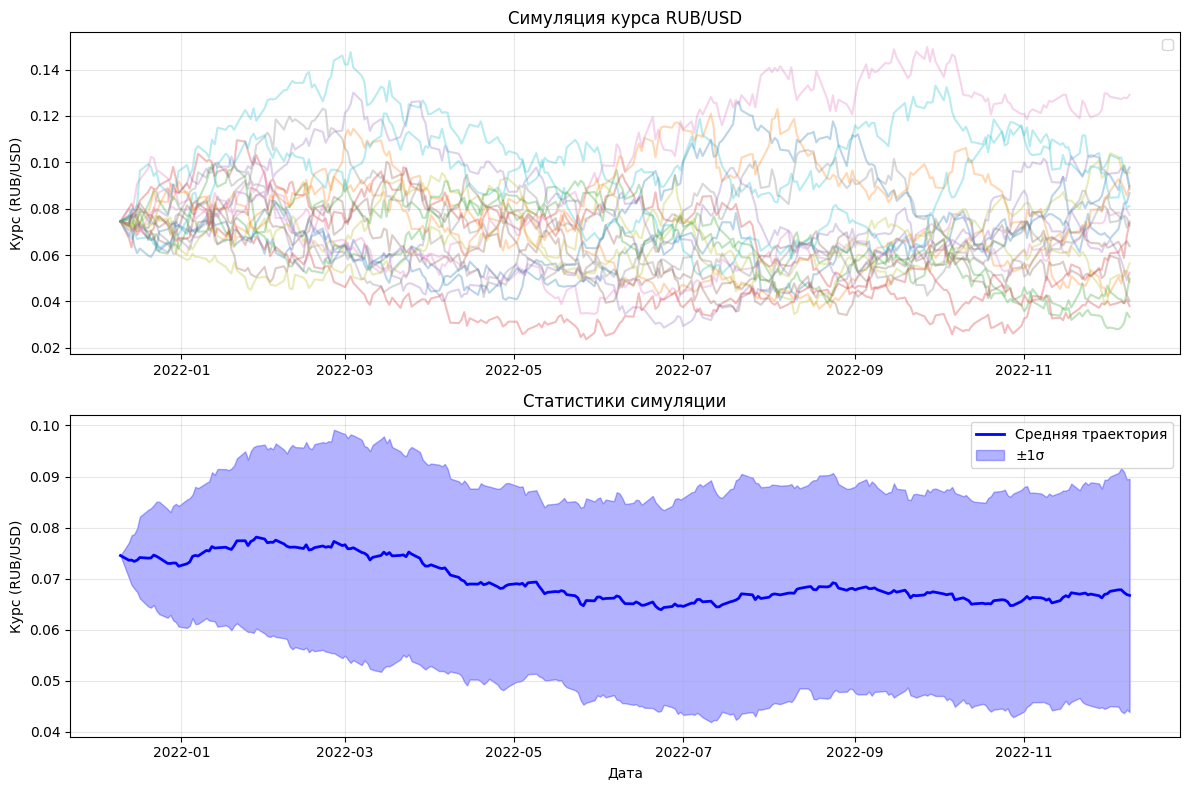

In [17]:
plot_simulation(
    dates=dates,
    trajectories=trajectories,
    model_type="fx",
    title="Симуляция курса RUB/USD",
    asset_type="fx",
)